In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing/anscombe.csv
/kaggle/input/housing/housing.csv


In [48]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/kaggle/input/housing/housing.csv")

In [49]:
df.shape

(20640, 10)

In [50]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


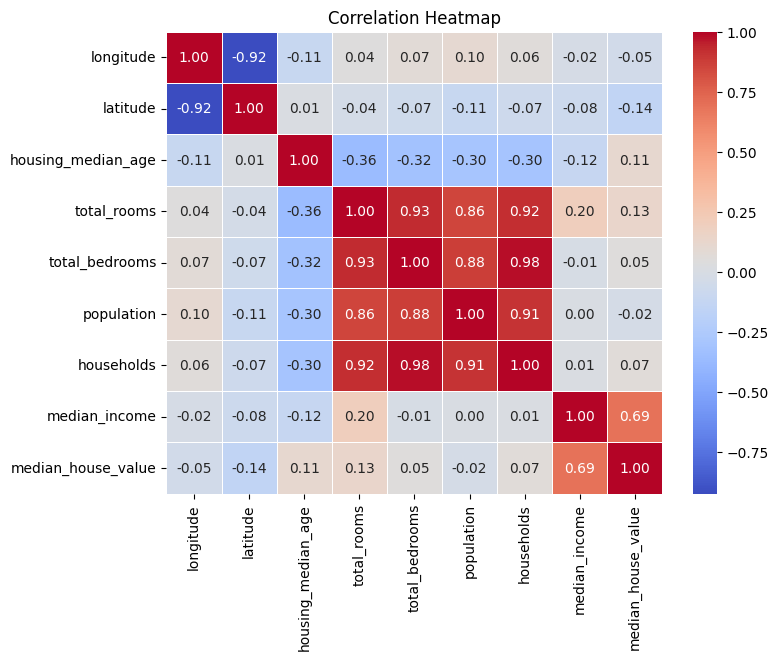

In [51]:
correlation_matrix = df.corr(numeric_only=True)

# Create a heatmap with correlation values
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

<Axes: >

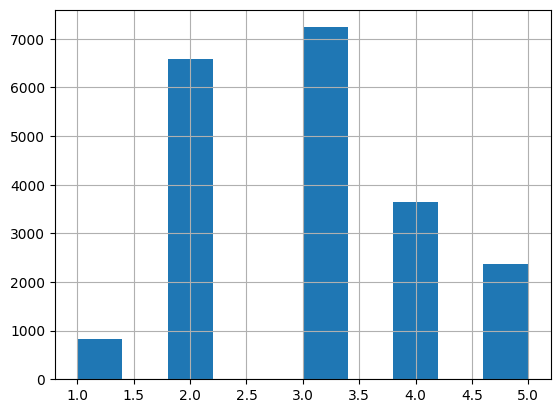

In [52]:
df["income_cat"]=pd.cut(df["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])
df["income_cat"].hist()

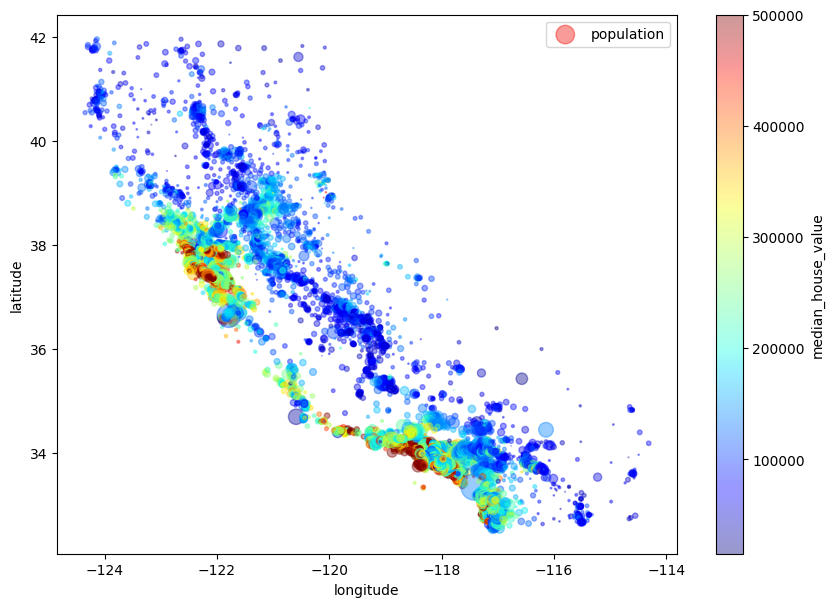

In [53]:
df.plot(kind="scatter",x='longitude',y='latitude',alpha=0.4,
             s=df["population"]/100,label="population",figsize=(10,7),
            c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True,
            )
plt.legend()

In [54]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [55]:
import numpy as np
import pandas as pd

def handle_outliers(df, target_column, z_threshold=3.2, remove_outliers=True):

    

    
    z_scores = np.abs((df[target_column] - df[target_column].mean()) / df[target_column].std())

    # Identify outliers based on the threshold
    outliers = df[z_scores > z_threshold]

    # Display the number of outliers
    print("Number of outliers:", len(outliers),'the column is ', target_column)

    

    # Remove outliers if specified
    deleted_rows = 0
    if remove_outliers:
        deleted_rows = len(outliers)
        df = df[z_scores <= z_threshold]
        print("hi")       
 
    return df

numerical_columns = df.select_dtypes(include=[np.number]).columns
for column in numerical_columns:
    
    df = handle_outliers(df, column)



# Display the updated DataFrame shape
print("Updated DataFrame shape:", df.shape)


Number of outliers: 0 the column is  longitude
hi
Number of outliers: 0 the column is  latitude
hi
Number of outliers: 0 the column is  housing_median_age
hi
Number of outliers: 328 the column is  total_rooms
hi
Number of outliers: 302 the column is  total_bedrooms
hi
Number of outliers: 226 the column is  population
hi
Number of outliers: 172 the column is  households
hi
Number of outliers: 298 the column is  median_income
hi
Number of outliers: 0 the column is  median_house_value
hi
Updated DataFrame shape: (19109, 11)


In [56]:
from sklearn.base import BaseEstimator,TransformerMixin
rooms_ix,bedroom_ix,population_ix,households_ix=3,4,5,6
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedroom_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor


num_pipeline = Pipeline([
  ("imputer",SimpleImputer(strategy="mean")),
    ("attribs_adder",CombinedAttributesAdder()),
    ("std_scaler",StandardScaler()),
    
])

In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
housing_num =df.drop(["ocean_proximity",'median_house_value'],axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat",OneHotEncoder(),cat_attribs),
])

In [77]:
y= df['median_house_value']
X = df.drop("median_house_value",axis=1)

X_final = full_pipeline.fit_transform(X)

In [139]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_final,y,test_size=0.2,random_state=1111)

In [140]:
from sklearn.neighbors import KNeighborsRegressor

In [141]:
knn_rmses = []
for i in range(1,15):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    knn_rmse=(MSE(y_test,y_pred))**0.5
    knn_r2=r2_score(y_test,y_pred)
    knn_rmses.append(knn_rmse)

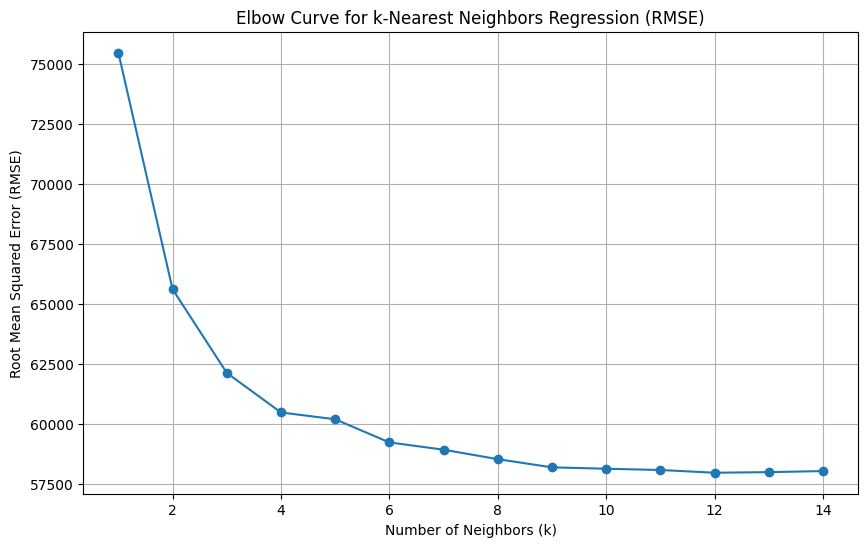

In [142]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), knn_rmses, marker='o')
plt.title('Elbow Curve for k-Nearest Neighbors Regression (RMSE)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.show()

In [143]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate 
lr = LinearRegression()
knn = knn = KNeighborsRegressor(n_neighbors=8)
lr_cv = cross_validate (lr,X_train,y_train,cv=5,scoring=['r2','neg_mean_squared_error'])
knn_cv = cross_validate (knn,X_train,y_train,cv=5,scoring=['r2','neg_mean_squared_error'])


In [144]:
best_lr_r2 = np.max(lr_cv['test_r2'])
lr_rmse = np.sqrt(-np.max(lr_cv['test_neg_mean_squared_error']))
best_knn_r2 = np.max(knn_cv['test_r2'])
knn_rmse = np.sqrt(-np.max(knn_cv['test_neg_mean_squared_error']))

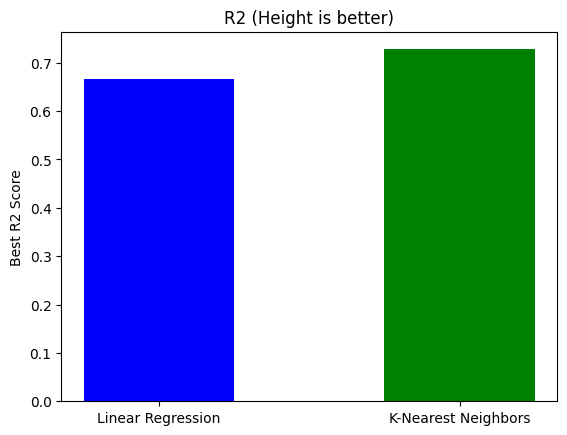

In [145]:
labels = ['Linear Regression', 'K-Nearest Neighbors']
values = [best_lr_r2, best_knn_r2]


colors = ['blue', 'green']

# Plotting
plt.bar(labels, values, color=colors,width=0.5)
plt.ylabel('Best R2 Score')
plt.title('R2 (Height is better)')
plt.show()

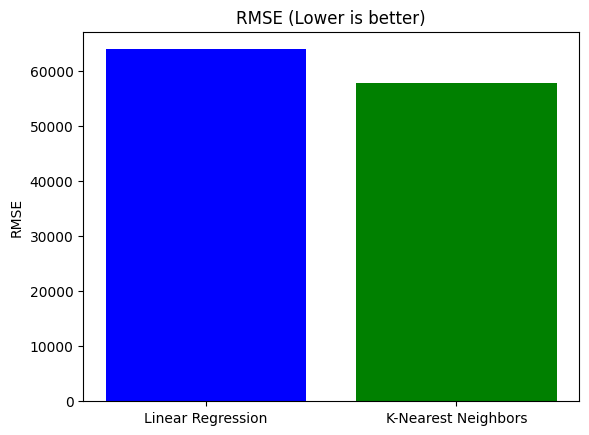

In [146]:
labels = ['Linear Regression', 'K-Nearest Neighbors']
values = [lr_rmse, knn_rmse]
colors = ['blue', 'green']

plt.bar(labels, values, color=colors)
plt.ylabel('RMSE')
plt.title('RMSE (Lower is better)')

plt.show()

In [148]:
from sklearn.metrics import mean_squared_error, r2_score
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


r2 = r2_score(y_test, y_pred)


print(f'RMSE: {rmse:.2f}')
print(f'R2 Score: {r2:.2f}')

RMSE: 65664.14
R2 Score: 0.64


In [149]:
knn.fit(X_train, y_train)


y_pred_knn = knn.predict(X_test)

rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))


r2_knn = r2_score(y_test, y_pred_knn)


print(f'K-Nearest Neighbors RMSE: {rmse_knn:.2f}')
print(f'K-Nearest Neighbors R2 Score: {r2_knn:.2f}')

K-Nearest Neighbors RMSE: 58518.26
K-Nearest Neighbors R2 Score: 0.72
